In [2]:


#@title Data loading
import os, requests

fname = []
for j in range(3):
  fname.append('steinmetz_part%d.npz'%j)

import numpy as np

alldat = np.array([])
for j in range(len(fname)):
  alldat = np.hstack((alldat, np.load('steinmetz_part%d.npz'%j, allow_pickle=True)['dat']))

In [8]:
import scipy
import scipy.signal

In [9]:
for i in range(39):
    no = len(np.unique(alldat[i]['brain_area']))
#     print('%02d %02d' %(i,no)) # 07, 12__15

In [10]:
alldat[7]['spks'].shape

(1156, 250, 250)

In [11]:
def detrend_XYR(data):
    data_detrend = scipy.signal.detrend(data, axis=-1, type='linear', bp=0, overwrite_data=False)
    return data_detrend

In [12]:
areas = np.unique(alldat[7]['brain_area'])
data = np.zeros((len(areas),250,250))
data_detrend = np.zeros((len(areas),250,250))
data_de_alltrial = np.zeros((len(areas),250*250))

for i,area in enumerate(areas):
    index = np.where(alldat[7]['brain_area'] == area)[0]
    data[i] = np.mean(alldat[7]['spks'][index][1:100],axis=0)
    data_detrend[i] = detrend_XYR(data[i])
    data_de_alltrial[i] = detrend_XYR(data[i].flatten())

In [13]:
import numpy as np
import pandas as pd
from sklearn.linear_model import BayesianRidge, LinearRegression, ElasticNet
from sklearn.svm import SVR
from sklearn.ensemble.gradient_boosting import GradientBoostingRegressor   # 集成算法
from sklearn.model_selection import cross_val_score    # 交叉验证
from sklearn.metrics import explained_variance_score, mean_absolute_error, mean_squared_error, r2_score  
import matplotlib.pyplot as plt
import seaborn as sns
import scipy 
import scipy.signal

C:\Users\lenovo\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.ensemble.gradient_boosting module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part of the private API.
  warnings.warn(message, FutureWarning)


In [14]:
def Linear_regression_XYR(X,y,n_folds=5):
    model = LinearRegression()
    scores = cross_val_score(model, X, y, cv=n_folds)
    pre_y=model.fit(X, y).predict(X)
    tmp_score = mean_squared_error(y, pre_y)
    return tmp_score

In [15]:
def make_design_matrix_XYR(activity, d):
    T = len(activity)  # Total number of timepoints (hint: number of stimulus frames)
    X = np.zeros((T-d, d))
    for t in range(T-d):
        X[t,:] = activity[t:t+d]
    return X

In [16]:
def model_Fit_XYR(X,Y,unionLag,autoLag=10):
    
    auto_x = make_design_matrix_XYR(Y,autoLag)
    auto_y = Y[autoLag:]
    auto_sig = Linear_regression_XYR(auto_x,auto_y)
    
    union_x = np.column_stack([make_design_matrix_XYR(Y,unionLag),make_design_matrix_XYR(X,unionLag)])
    union_y = Y[unionLag:]
    union_sig = Linear_regression_XYR(union_x,union_y)
    
    return auto_sig, union_sig

In [17]:
"""
res_dic = {}
    
def GC_main_XYR(data,variables,unionLags):
    # unionLags = range(50,100,5)
    for unionLag in unionLags:
        df_F = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
        df_P = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
        for i in range(len(variables)):
            for j in range(len(variables)):
                auto_sig, union_sig = model_Fit_XYR(data[i,:].flatten(),data[j,:].flatten(),unionLag)
                df_F.loc[variables[i],variables[j]] = auto_sig/union_sig
                df_P.loc[variables[i],variables[j]] = 1-scipy.stats.f.cdf(df_F.loc[variables[i],variables[j]], len(data)-auto_sig+1, len(data)-union_sig+1)
        res_dic['%03d' %(unionLag)] = {'F':df_F,'p':df_P}
    return res_dic
"""

"\nres_dic = {}\n    \ndef GC_main_XYR(data,variables,unionLags):\n    # unionLags = range(50,100,5)\n    for unionLag in unionLags:\n        df_F = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)\n        df_P = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)\n        for i in range(len(variables)):\n            for j in range(len(variables)):\n                auto_sig, union_sig = model_Fit_XYR(data[i,:].flatten(),data[j,:].flatten(),unionLag)\n                df_F.loc[variables[i],variables[j]] = auto_sig/union_sig\n                df_P.loc[variables[i],variables[j]] = 1-scipy.stats.f.cdf(df_F.loc[variables[i],variables[j]], len(data)-auto_sig+1, len(data)-union_sig+1)\n        res_dic['%03d' %(unionLag)] = {'F':df_F,'p':df_P}\n    return res_dic\n"

In [18]:
def GC_main_XYR(data,variables,unionLag):
    #unionLags = range(50,100,5)
    #res_dic = {}
    df_F = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    df_P = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for i in range(len(variables)):
        for j in range(len(variables)):
            auto_sig, union_sig = model_Fit_XYR(data[i,:].flatten(),data[j,:].flatten(),unionLag)
            df_F.loc[variables[i],variables[j]] = auto_sig/union_sig
            df_P.loc[variables[i],variables[j]] = 1-scipy.stats.f.cdf(df_F.loc[variables[i],variables[j]], len(data)-auto_sig+1, len(data)-union_sig+1)
    res_dic = {'F':df_F,'p':df_P}
    return res_dic

In [19]:
#unionLags = range(40,50,5)
#res=GC_main_XYR(data_detrend[:,0,:],areas,unionLags)
#res['045']['F']

In [20]:
#order_dic = {}
#for i in range(len(areas)):
#    for j in range(len(areas)):
#        fvalue = [res['%03d' %(unionLag)]['F'].loc[areas[i],areas[j]] for unionLag in unionLags]
#        order = 20+5*np.argmin(-1*np.array(fvalue))
#        order_dic[areas[i]+'_'+areas[j]]=order 

基本都是45阶，所以干脆全部用45分析。

In [65]:

per_trial = []
for i in range(250):
    per_trial.append(GC_main_XYR(data_detrend[:,i,:],areas,45)['F'])

In [66]:
a = per_trial[0]

<AxesSubplot:>

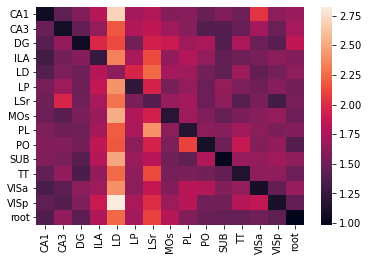

In [67]:
import seaborn
import networkx as nx
from networkx import from_numpy_array, draw_networkx,eigenvector_centrality, average_shortest_path_length, harmonic_centrality, global_efficiency

from matplotlib.pyplot import figure
#figure(figsize=(6, 5), dpi=80)


seaborn.heatmap(a)

In [68]:
np.save('GC_matrix', np.array(per_trial))